## Basics

In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
# Load the signal and print it's properties

fs, data = wavfile.read('../audio/xmacho12.wav')
t = data.size / fs

print(f'Loaded signal has {data.size} samples.')
print(f'That is {t} seconds with sampling frequency of {fs} Hz.')
print(f'Mininum value is {data.min()}, maximum {data.max()}.')

Loaded signal has 45056 samples.
That is 2.816 seconds with sampling frequency of 16000 Hz.
Mininum value is -1909, maximum 3584.


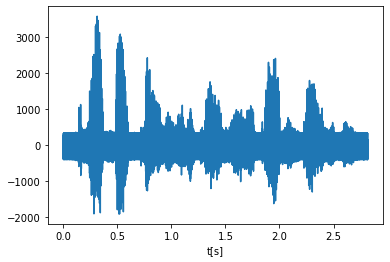

In [3]:
# Convert the x axis to seconds
x = np.arange(data.size) / fs

# Do the plotting
plt.plot(x, data)
plt.gca().set_xlabel('t[s]')

plt.savefig('../doc/img/basic.pdf')

## Preprocessing and frames

In [4]:
# Ustredneni signalu
data = data - data.mean()

# Normalization
scale = np.abs(data).max()
data = data / scale

print(f'Mean: {data.mean()}, Maximum: {data.max()}, Minimum: {data.min()}')

Mean: 1.3552527156068805e-18, Maximum: 1.0, Minimum: -0.532249560351968


In [5]:
# Split the signal into chunks
chunkSize = 512
numChunks = int(np.floor(data.size / chunkSize))
chunkedArray = data.reshape(numChunks, chunkSize)

# Create the matrix of frames
frameSize = chunkSize * 2
frames = np.empty((frameSize, numChunks-1), dtype=float)

for i in range(numChunks-1):
    frames[:, i] = np.concatenate((chunkedArray[i], chunkedArray[i+1]))

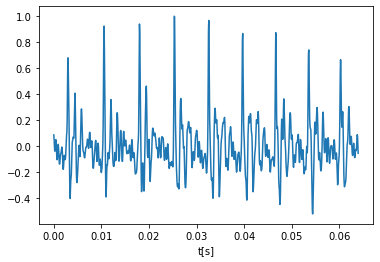

In [6]:
# Plot one nice frame
# Convert the x axis to seconds
frameTimeAxis = np.arange(frameSize) / fs

chosenFrame = frames[:, 9]
# Do the plotting
plt.plot(frameTimeAxis, chosenFrame)
plt.gca().set_xlabel('t[s]')

plt.savefig('../doc/img/frame.pdf')

## DFT

In [7]:
# Construct the DFT matrix
# It will be later used to multiply each frame
N = 1024
DFT_BASES = np.empty((N, N), dtype=np.cfloat)

for n in range(N):
    for k in range(N):
        DFT_BASES[n,k] = np.exp(-2j * np.pi * n * k / N)

In [8]:
# signal should be a vector of 1024 samples
def DFT(signal):
    coefficients = np.matmul(DFT_BASES, signal)
    return coefficients

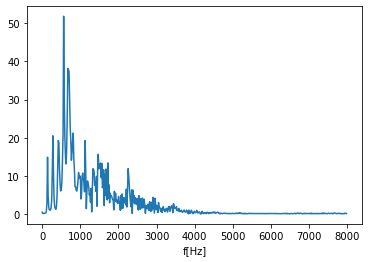

In [9]:
# Check if the function works
transform = DFT(chosenFrame)

# The highest dispayed frequency is the half of fs
N_DISP = int(N/2) - 1

y_axis = np.abs(transform[:N_DISP])
x_axis = np.arange(N_DISP)/N_DISP * (fs/2)

plt.plot(x_axis, y_axis)
plt.gca().set_xlabel('f[Hz]')

plt.savefig('../doc/img/DFT.pdf')

'Everything OK'

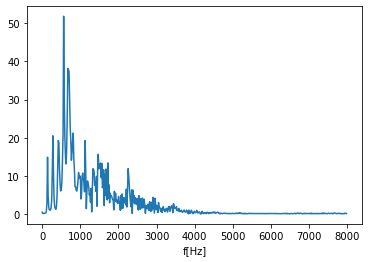

In [10]:
correct = np.fft.fft(chosenFrame)

y_axis = np.abs(correct[:N_DISP])
x_axis = np.arange(N_DISP)/N_DISP * (fs/2)

plt.plot(x_axis, y_axis)
plt.gca().set_xlabel('f[Hz]')

'Everything OK' if np.allclose(correct, transform) else 'Oof'

##  Spectrogram

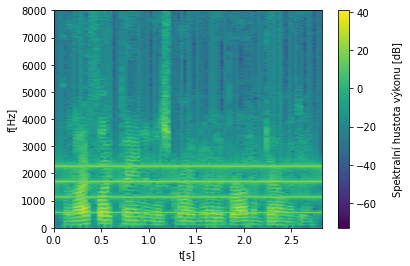

In [11]:
def spectrogram(frames):
    # Transform all frames at once
    # By matrix multiplication with all the bases
    spectrogram = np.matmul(DFT_BASES, frames)

    # Cut off the unwanted frequencies above fs/2
    spectrogram = spectrogram[:N_DISP]
    # We only care about modules, not the angles
    spectrogram = np.abs(spectrogram)

    spectrogram = 10 * np.log10(np.power(spectrogram, 2))

    # Show the spectrogram
    plt.imshow(spectrogram,
               origin='lower',
               extent=[0, t, 0, fs/2],
               aspect='auto',
              )
    plt.gca().set_xlabel('t[s]')
    plt.gca().set_ylabel('f[Hz]')
    plt.colorbar().set_label('Spektralní hustota výkonu [dB]', rotation=90, labelpad=15)
    
spectrogram(frames)
plt.savefig('../doc/img/spectrogram.pdf')

## Identification of the added frequencies

In [12]:
# Transform the second frame
# because there is no voice in it
noise_frame = frames[:, 1]

# again, we only case about absolute value
frequencies = np.abs(DFT(noise_frame))[:511]

# If the peaks are narrow enough - which they seem to be
# We can just get the 4 strongest frequencies
peak_indices = frequencies.argsort()[-4:]

# Convert to real frequency in Hz
peaks_real = peak_indices/N * fs

for peak_freq in peaks_real:
    print(f'{peak_freq} Hz')

2250.0 Hz
1687.5 Hz
1125.0 Hz
562.5 Hz


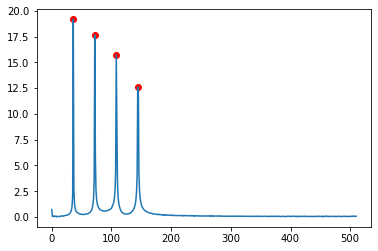

In [13]:
plt.plot(frequencies)
plt.scatter(peak_indices, frequencies[peak_indices], color='red')
plt.savefig('../doc/img/peaks.pdf')
plt.show()

## Signal generation

In [14]:
SAMPLING_FREQ = fs
# Signal will be 5 seconds long
NUM_SAMPLES = data.size
# The list of generated frequencies
FREQS = np.array([562.5, 1125, 1687.5, 2250])
output = np.zeros(NUM_SAMPLES)

for frequency in FREQS:
    normalized_freq = frequency / SAMPLING_FREQ
    omega = normalized_freq * 2 * np.pi
    signal = np.cos(np.arange(NUM_SAMPLES) * omega)
    # We do not want to normalize the output,
    # So we just divide the signal by number of added frequencies
    # If all signals are at their peaks, the maximum is exactly 1
    output += signal.copy() / FREQS.size

wavfile.write('../audio/4cos.wav', SAMPLING_FREQ, output)

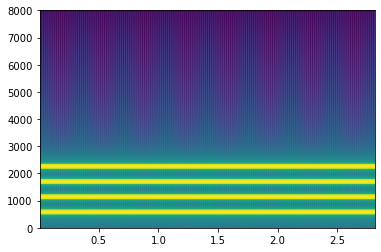

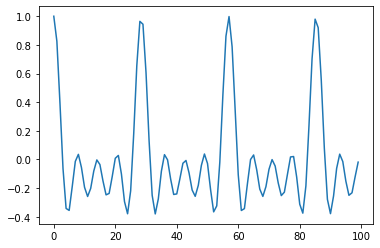

In [15]:
# Plot the spectrogram to confirm similarity
plt.specgram(output, Fs=SAMPLING_FREQ)
plt.savefig('../doc/img/4cos_spec.pdf')
plt.show()
plt.plot(output[:100])
plt.savefig('../doc/img/4cos.pdf')
plt.show()

## Cleaning filter

In [16]:
spec_filter_half = np.ones(int(N/2))

for peak in peak_indices:
    spec_filter_half[peak] = 0.0
    
spec_filter = np.concatenate((spec_filter_half, np.flip(spec_filter_half)))

In [17]:
# This smarter filter will not only kill the most prominent spikes
# but also the frequencies near them
# it is calibrated with the original beep signal
spec_filter_smart = 1 / np.exp(np.abs(np.fft.fft(frames[:, 1])))

In [19]:
nyq = fs/2

STOP_WIDTH = 30/nyq
TRANS_WIDTH = 50/nyq
GPASS = 3 # 3dB
GSTOP = 40 # 40dB

butter_filters = []
zeros = []
poles = []

for f in peaks_real:
    nf = f/nyq
    N, Wn = scipy.signal.buttord(
        [nf - TRANS_WIDTH - STOP_WIDTH/2, nf + TRANS_WIDTH + STOP_WIDTH/2],
        [nf - STOP_WIDTH/2, nf + STOP_WIDTH/2],
        GPASS,
        GSTOP
    )
    
    butter_filters.append(scipy.signal.butter(N, Wn, 'bandstop'))
    z, p, _ = scipy.signal.butter(N, Wn, 'bandstop', output='zpk')
    zeros.append(z)
    poles.append(p)


## Zero points and poles

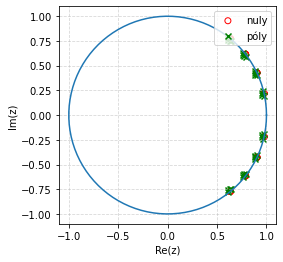

In [20]:
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='g', label='póly')

plt.axis('square')

plt.gca().set_xlabel('Re(z)')
plt.gca().set_ylabel('Im(z)')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.savefig('../doc/img/zplane.pdf')

## Frequency characteristics

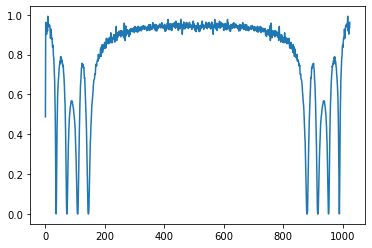

In [28]:
#plt.plot(np.abs(spec_filter))
plt.plot(np.abs(spec_filter_smart))
plt.savefig('../doc/img/filter_spec.pdf')
plt.show()

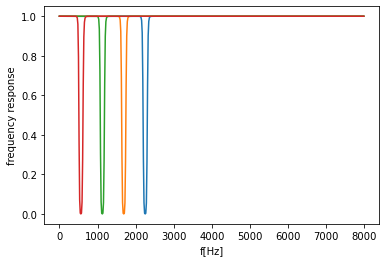

In [22]:
for b, a in butter_filters:
    w, h = scipy.signal.freqz(b, a)
    plt.plot(w/np.pi*nyq, np.abs(h))
    
plt.gca().set_xlabel('f[Hz]')
plt.gca().set_ylabel('frequency response')
plt.savefig('../doc/img/filter_butter.pdf')
plt.show()

## Filtration

In [23]:
fs, data = wavfile.read('../audio/xmacho12.wav')
data = data / 2**15

transformed = np.empty(frames.shape, dtype='cfloat')

# Transform the original signal
for i in range(frames.shape[1]):
    transformed[:, i] = np.fft.fft(frames[:, i])

filtered = np.empty(transformed.shape, dtype='cfloat')

# Do the filtering
filtered = (transformed.transpose() * spec_filter_smart).transpose()
    
chunked_output = np.empty(frames.shape)

# Transform the fourier coefficients back into a signal
for i in range(frames.shape[1]):
    chunked_output[:, i] = np.real(np.fft.ifft(filtered[:, i]))

# Take only the middle of the transformed signals
# The ends are kinda rough
output = chunked_output.transpose()[: ,256:767].flatten()
    
wavfile.write('../audio/clean_spec.wav', fs, output)

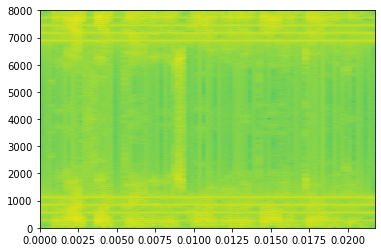

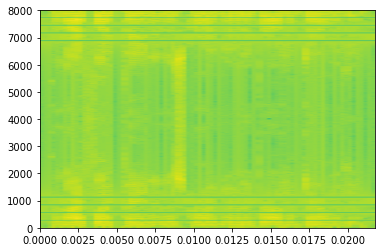

In [24]:
plt.imshow(10 * np.log10(np.power(np.abs(transformed), 2)),
           origin='lower',
           extent=[0, frames.shape[1]*N/fs, 0, fs/2],
           aspect='auto',
          )
plt.show()

plt.imshow(10 * np.log10(np.power(np.abs(filtered), 2)),
           origin='lower',
           extent=[0, frames.shape[1]*N/fs, 0, fs/2],
           aspect='auto',
          )
plt.show()

In [25]:
spec_filter_smart.shape

(1024,)

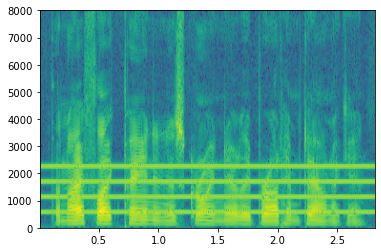

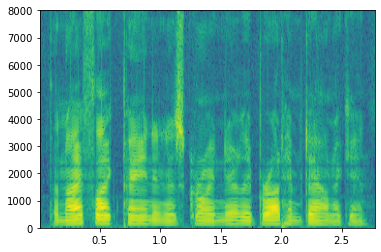

In [26]:
plt.specgram(data, Fs=SAMPLING_FREQ)
plt.savefig('../doc/img/before.pdf')
plt.show()
plt.specgram(output, Fs=SAMPLING_FREQ)
plt.savefig('../doc/img/after.pdf')
plt.show()

In [27]:
filtered_butter = data
for b, a in butter_filters:
    filtered_butter = scipy.signal.lfilter(b, a, filtered_butter)
    
wavfile.write('../audio/clean_butter.wav', fs, output)